# Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from statsmodels.api import OLS
import statsmodels.api as sm
from sklearn import set_config
import numpy as np
set_config(display='diagram')
from sklearn.linear_model import Ridge


In [26]:
y_val = pd.read_csv('..//y_values.csv')

df = pd.read_parquet('..//raw_data//coin_id_formated.parquet')
df.head()

,id,symbol,name,asset_platform_id,hashing_algorithm,categories,description,country_origin,sentiment_votes_up_percentage,sentiment_votes_down_percentage,market_cap_rank,coingecko_rank,coingecko_score,community_score,liquidity_score,twitter_followers,telegram_channel_user_count
0,01coin,zoc,zoc,nan,NeoScrypt,[Masternodes],,nan,NaN,NaN,NaN,2463,14.726,15.272,1.0,366.0,243.0
1,0-5x-long-algorand-token,algohalf,algohalf,ethereum,nan,[],0.5X Long Algorand Token (ALGOHALF) is an ERC2...,nan,NaN,NaN,NaN,12804,0.2,0.0,1.0,0.0,NaN
2,0-5x-long-altcoin-index-token,althalf,althalf,ethereum,nan,[],0.5X Long Altcoin Index Token (ALTHALF) is an ...,nan,NaN,NaN,NaN,13244,0.0,0.0,0.0,0.0,NaN
3,0-5x-long-ascendex-token-token,asdhalf,asdhalf,ethereum,nan,[],0.5X Long AscendEx Token (BTMX) Token (ASDHALF...,nan,NaN,NaN,NaN,13159,0.0,0.0,0.0,0.0,NaN
4,0-5x-long-bitcoin-cash-token,bchhalf,bchhalf,ethereum,nan,[],0.5X Long Bitcoin Cash Token (BCHHALF) is an E...,nan,NaN,NaN,NaN,12978,0.2,0.0,1.0,0.0,NaN


In [27]:
str_cols = ['id', 'symbol', 'name', 'asset_platform_id', 'hashing_algorithm','description','country_origin']
df[str_cols] = df[str_cols].astype(str)
float_cols = ['sentiment_votes_up_percentage', 'sentiment_votes_down_percentage','market_cap_rank', ]
df[float_cols] = df[float_cols].astype(float)
int_cols = ['coingecko_rank', 'coingecko_score','community_score', 'liquidity_score', 'twitter_followers',
       'telegram_channel_user_count']       
df[int_cols] = df[int_cols].astype(float)


### Analisando as categorias

In [28]:
df['categories'] = [
    x.tolist() if len(x.tolist()) != 0 else [None] for x in df['categories']
]
catHandler = pd.DataFrame(df['categories'].to_list(),
                          index=df['id']).values.ravel('K')

uniCats = pd.unique(catHandler)
uniCats = [x for x in uniCats if (x != None)]

df_cat_dummies = pd.DataFrame(index=df.id, columns=uniCats)

for coin, categories in df[['id', 'categories']].to_numpy():

    for categorie in categories:

        df_cat_dummies.loc[coin, categorie] = 1
        
df_cat_dummies.drop([None], axis=1, inplace=True)

In [29]:
df_cat_dummies = df_cat_dummies.fillna(0).astype(int)

<AxesSubplot:>

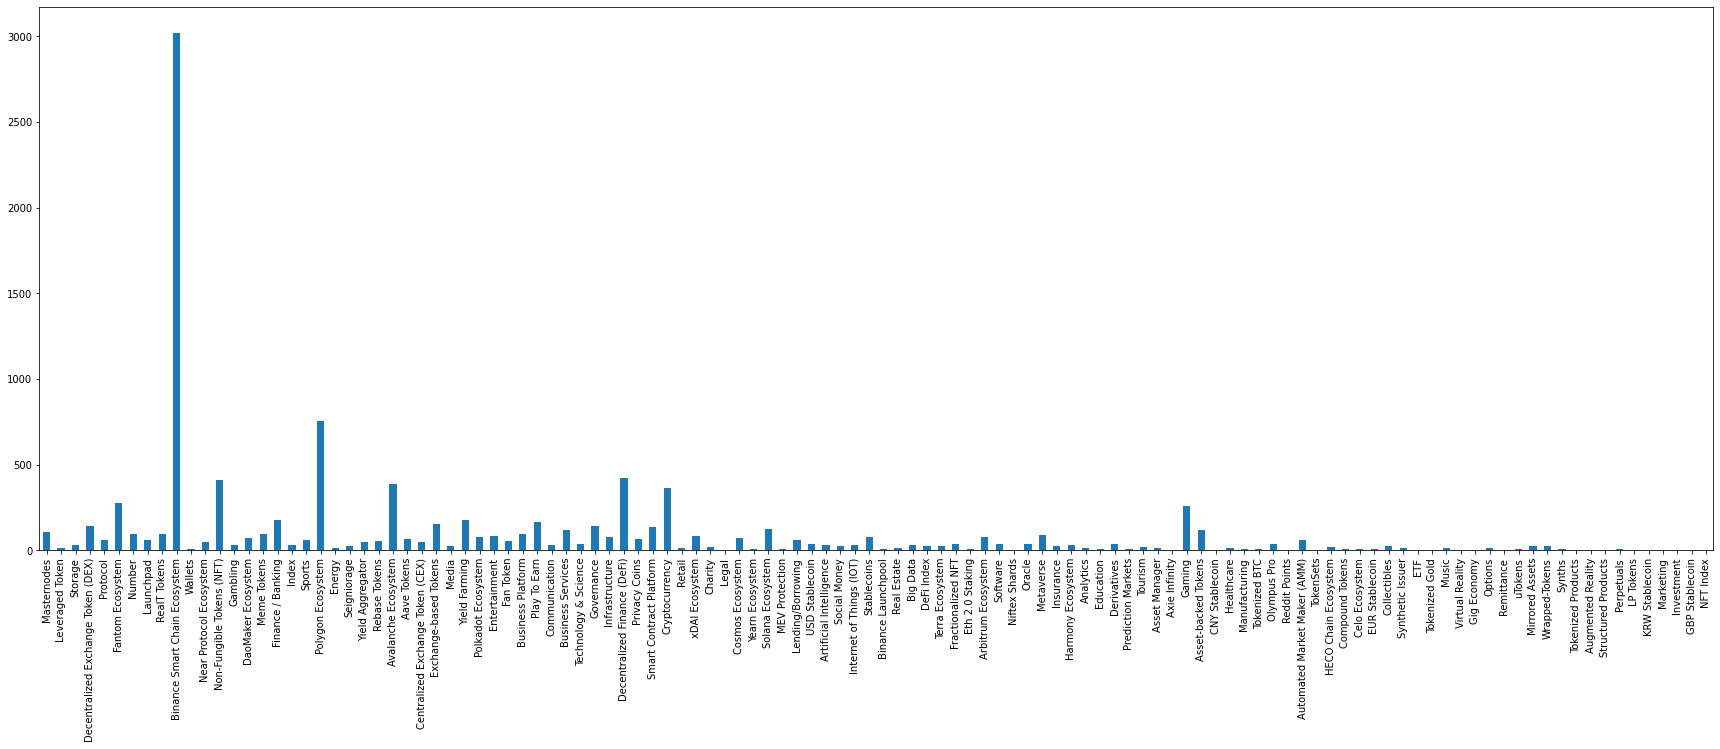

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))
df_cat_dummies.sum().plot(kind='bar')

In [31]:
ecossystens = []
for x in df_cat_dummies.columns:
    if x.split()[-1] == 'Ecosystem':
        ecossystens.append(x)
        print(x)

Fantom Ecosystem
Binance Smart Chain Ecosystem
Near Protocol Ecosystem
DaoMaker Ecosystem
Polygon Ecosystem
Avalanche Ecosystem
Polkadot Ecosystem
xDAI Ecosystem
Cosmos Ecosystem
Yearn Ecosystem
Solana Ecosystem
Terra Ecosystem
Arbitrum Ecosystem
Harmony Ecosystem
HECO Chain Ecosystem
Celo Ecosystem


<AxesSubplot:>

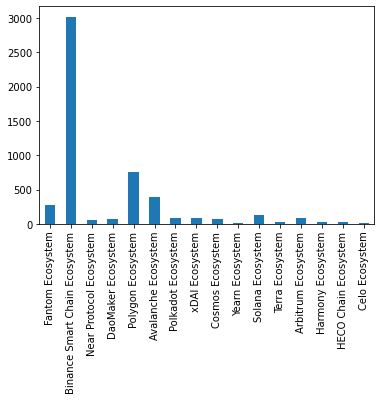

In [32]:
df_cat_dummies[ecossystens].sum().plot(kind='bar')

In [33]:
df_cat_dummies.to_parquet("../raw_data/dummy_categories.parquet.gzip")

In [33]:
df_completo_categorias = df.merge(df_cat_dummies, left_on="id", right_index=True).drop("categories", axis=1)

In [35]:
df_completo_categorias.to_parquet("../raw_data/coin_id_with_categories.parquet.gzip")

In [38]:
y_val.columns[0]

'Unnamed: 0'

In [41]:
df_completo_y = df_completo_categorias.merge(y_val, left_on='id', right_on='Unnamed: 0').drop("Unnamed: 0", axis=1)
df_completo_y.to_parquet("../coin_COMPLETO.parquet.gzip")

## Modelo de Regressao

###  Analise de Variaveis

In [38]:
df_completo_categorias.describe()


,sentiment_votes_up_percentage,sentiment_votes_down_percentage,market_cap_rank,coingecko_rank,coingecko_score,community_score,liquidity_score,twitter_followers,telegram_channel_user_count,Masternodes,...,Tokenized Products,Augmented Reality,Structured Products,Perpetuals,LP Tokens,KRW Stablecoin,Marketing,Investment,GBP Stablecoin,NFT Index
count,5466.000000,5466.000000,3805.000000,13508.00000,13675.000000,13675.000000,13675.000000,1.366700e+04,1.138700e+04,13675.000000,...,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000,13675.000000
mean,72.713251,27.286760,1907.155059,6755.00459,7.799963,10.932654,5.881238,3.898929e+04,1.182694e+04,0.007898,...,0.000219,0.000366,0.000293,0.000804,0.000293,0.000073,0.000146,0.000219,0.000073,0.000366
std,34.601871,34.601869,1127.256097,3900.60744,9.233664,9.774672,11.903772,2.494933e+05,2.962778e+04,0.088520,...,0.014810,0.019119,0.017101,0.028351,0.017101,0.008551,0.012093,0.014810,0.008551,0.019119
min,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,950.000000,3377.75000,1.817500,6.360500,1.000000,4.840000e+02,9.820000e+02,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,87.500000,12.500000,1903.000000,6754.50000,3.733000,8.661000,1.000000,5.465000e+03,3.215000e+03,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100.000000,50.000000,2853.000000,10131.00000,11.808000,10.778500,2.697500,2.579400e+04,1.124400e+04,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,13284.000000,13510.00000,81.034000,85.250000,106.715000,1.186877e+07,1.432776e+06,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:ylabel='Frequency'>

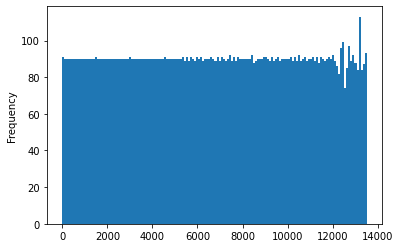

In [39]:
df[df['coingecko_rank'] != 0]['coingecko_rank'].plot(kind='hist', bins=150)


<AxesSubplot:ylabel='Frequency'>

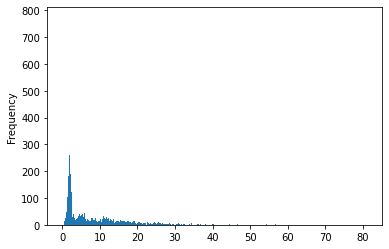

In [24]:
df[df['coingecko_score'] != 0]['coingecko_score'].plot(kind='hist', bins=1500)


<AxesSubplot:ylabel='Frequency'>

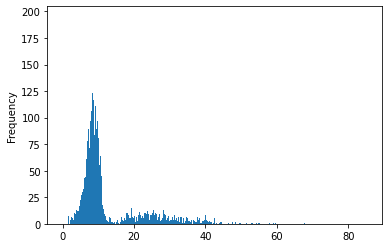

In [25]:
df[df['community_score'] != 0]['community_score'].plot(kind='hist', bins=1500)


<AxesSubplot:ylabel='Frequency'>

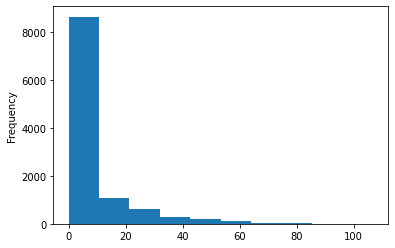

In [32]:
df[df['liquidity_score'] != 0]['liquidity_score'].plot(kind='hist')


<AxesSubplot:ylabel='Frequency'>

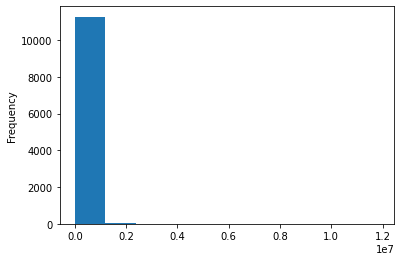

In [33]:
df[df['twitter_followers'] != 0]['twitter_followers'].plot(kind='hist')


### Build Pipeline

#### Caso queira customizar alguma função

In [ ]:
def multiply(df):
    return pd.DataFrame(df['product_length_cm'] * df['product_height_cm'] *
                        df['product_width_cm'])


volume_computer = Pipeline([('compute_volume', FunctionTransformer(multiply)),
                            ('scale_volume', MinMaxScaler())])

final_preprocessor = ColumnTransformer([
    ('num_encoder', MinMaxScaler(),
     make_column_selector(dtype_include="int64")),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False),
     make_column_selector(dtype_include="object")),
    ('volume_computer', volume_computer,
     ['product_length_cm', 'product_height_cm', 'product_width_cm'])
])

pipe = Pipeline([('preprocessing', final_preprocessor),
                 ('linear_regression', Ridge())])

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_encoder', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe948dc6c10>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe948dc6dc0>),
                                                 ('volume_computer',
                                                  Pipeline(steps=[('compute_volume',
                                                                   FunctionTransformer(func=<function multiply at 0x7fe948e761f0>)),
                                                                  ('scale_volume',
                                                                   MinMaxScaler())]),
                                                  ['product_length_cm',
                                                   'product_height_cm',
                                                   'product_width_cm'])])),
                ('linear_regression', Ridge())])

#### Caso use as padrões

In [ ]:


final_preprocessor = ColumnTransformer([
    ('num_encoder', MinMaxScaler(),
     make_column_selector(dtype_include="float64")),

    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False),
     make_column_selector(dtype_include="object"))])

pipe = Pipeline([('preprocessing', final_preprocessor),
                 ('linear_regression', Ridge())])

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_encoder', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe942e0b1c0>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe942e0baf0>)])),
                ('linear_regression', Ridge())])

In [ ]:
pipe.fit_transform(df)

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['ndarray']